In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
from visualization import *
from util_tsne_exact import *
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

from sympy import *
init_printing()


## Symbolically Calculate the Cost per Part for Baseline 

In [19]:
it, D, N, d, T = symbols('it D N d T')
count_measure = ("add", "mult", "div", "exp", "log")
flops = {
    "normalize": {
        "add": 2 * N * D,
        "div": D + N * D
    },
    "compute_pairwise_affinity_perplexity": {
        "compute_squared_euclidean_distance": {
            "add": D * N * (N - 1) / 2 * 2,
            "mult": D * N * (N - 1) / 2
        },
        "binary_search": {
            "add": it * (N + N + 1 + 1),
            "mult": it * (N + 2 * N),
            "div": it * (1 + 1) + N * N,
            "exp": it * N,
            "log": it * (1 + 1)
        }
    },
    "symmetrize_affinities": {
        "add": N * (N - 1) / 2 + N * N,
        "div": N * N
    },
    "early_exageration": {
        "mult": 2 * N * N
    },
    "compute_low_dimensional_affinities": {
        "compute_squared_euclidean_distance": {
            "add": T * d * N * (N - 1) / 2 * 2,
            "mult": T * d * N * (N - 1) / 2
        },
        "compute": {
            "add": T * N * (N - 1) * 2,
            "div": T * N * (N - 1)
        }
    },
    "gradient_computation": {
        "add": T * N * (N - 1) * (1 + 2 * d),
        "mult": T * N * (N - 1) * (1 + d),
        "div": T * N * (N - 1)
    },
    "gradient_update": {
        "add": T * (N * d + N * d * 2),
        "mult": T * N * d * 3
    },
    "normalize_2": {
        "add": T * 2 * N * d,
        "div": T * (d + N * d)
    }
}

flops_by_function_measure = dict(flops)


In [20]:
cost_part_1 = {}
cost_part_2 = {}
cost_part_3 = {}

for c in flops_by_function_measure["compute_pairwise_affinity_perplexity"]["compute_squared_euclidean_distance"]:
    if c not in cost_part_1:
        cost_part_1[c] = 0
    cost_part_1[c] += flops_by_function_measure["compute_pairwise_affinity_perplexity"]["compute_squared_euclidean_distance"][c]
    
for c in flops_by_function_measure["normalize"]:
    if c not in cost_part_1:
        cost_part_1[c] = 0
    cost_part_1[c] += flops_by_function_measure["normalize"][c]
    
    
for c in flops_by_function_measure["compute_pairwise_affinity_perplexity"]["binary_search"]:
    if c not in cost_part_2:
        cost_part_2[c] = 0
    cost_part_2[c] += flops_by_function_measure["compute_pairwise_affinity_perplexity"]["binary_search"][c]

for c in flops_by_function_measure["symmetrize_affinities"]:
    if c not in cost_part_2:
        cost_part_2[c] = 0
    cost_part_2[c] += flops_by_function_measure["symmetrize_affinities"][c]
    
    
for c in flops_by_function_measure["early_exageration"]:
    if c not in cost_part_2:
        cost_part_2[c] = 0
    cost_part_2[c] += flops_by_function_measure["early_exageration"][c]/2

    
for t in ["gradient_computation", "gradient_update", "normalize_2"]:
    for c in flops_by_function_measure[t]:
        if c not in cost_part_3:
            cost_part_3[c] = 0
        cost_part_3[c] += flops_by_function_measure[t][c]/2

        
for c in flops_by_function_measure["early_exageration"]:
    if c not in cost_part_3:
        cost_part_3[c] = 0
    cost_part_3[c] += flops_by_function_measure["early_exageration"][c]/2

        
print("Part 1")
for c in cost_part_1:
    print(c, cost_part_1[c].simplify())

print()
print("Part 2")
for c in cost_part_2:
    print(c, cost_part_2[c].simplify(), "- -", cost_part_2[c].subs('it', 20*N).simplify())
    
print()
print("Part 3")
for c in cost_part_3:
    print(c, cost_part_3[c].simplify())

Part 1
add D*N*(N + 1)
mult D*N*(N - 1)/2
div D*(N + 1)

Part 2
add 3*N**2/2 + 2*N*it - N/2 + 2*it - - N*(83*N + 79)/2
mult N*(N + 3*it) - - 61*N**2
div 2*N**2 + 2*it - - 2*N*(N + 20)
exp N*it - - 20*N**2
log 2*it - - 40*N

Part 3
add N*T*(5*d + (N - 1)*(2*d + 1))/2
mult N*(2*N + 3*T*d + T*(N - 1)*(d + 1))/2
div T*(N*(N - 1) + d*(N + 1))/2


## Time spend per part Based on D

In [24]:
d500 = pd.read_csv("../code/implementations/tsne_exact_final/toaster_bench/D500.csv")
d1000 = pd.read_csv("../code/implementations/tsne_exact_final/toaster_bench/D1000.csv")
d2500 = pd.read_csv("../code/implementations/tsne_exact_final/toaster_bench/D2500.csv")

part1_500 = d500["pairwise_squared_euclidean_distance"]
part2_500 = d500["pairwise_affinity_perplexity"] + d500["symmetrize_affinities"]
part3_500 = d500["low_dimensional_affinities"] + d500["gradient_computation_update_normalize"]
part1_500 /= d500["total"]
part2_500 /= d500["total"]
part3_500 /= d500["total"]
part1_500 = part1_500[0]
part2_500 = part2_500[0]
part3_500 = part3_500[0]
print(part1_500*100, part2_500*100, part3_500*100)

part1_1000 = d1000["pairwise_squared_euclidean_distance"]
part2_1000 = d1000["pairwise_affinity_perplexity"] + d1000["symmetrize_affinities"]
part3_1000 = d1000["low_dimensional_affinities"] + d1000["gradient_computation_update_normalize"]
part1_1000 /= d1000["total"]
part2_1000 /= d1000["total"]
part3_1000 /= d1000["total"]
part1_1000 = part1_1000[0]
part2_1000 = part2_1000[0]
part3_1000 = part3_1000[0]
print(part1_1000*100, part2_1000*100, part3_1000*100)

part1_2500 = d2500["pairwise_squared_euclidean_distance"]
part2_2500 = d2500["pairwise_affinity_perplexity"] + d2500["symmetrize_affinities"]
part3_2500 = d2500["low_dimensional_affinities"] + d2500["gradient_computation_update_normalize"]
part1_2500 /= d2500["total"]
part2_2500 /= d2500["total"]
part3_2500 /= d2500["total"]
part1_2500 = part1_2500[0]
part2_2500 = part2_2500[0]
part3_2500 = part3_2500[0]
print(part1_2500*100, part2_2500*100, part3_2500*100)

4.48644654934 18.0571933685 77.4563600821
8.84400224532 17.2425723104 73.9134254443
23.3251350304 17.2769192406 59.397945729


## Calculating FLOPs per part

In [11]:
D = 28*28
d = 2
T = 1000

def get_flops(iters, implementation):
    assert implementation in ("baseline", "scalar", "avx")
    # Compute the flops for baseline
    N = iters["N"]
    it = iters["iters"]
    
    if implementation == "baseline":
        flops_distance_baseline = 3*N*D + D + (1.5)*D*N*(N-1)
        flops_perplexity_baseline = it * (2 * N + N + 3 * N + 7) + N**2
        flops_symmetrize_baseline = N * (N-1) / 2 + 3 * N**2
        flops_ld_affinities_baseline = T * (7 * N * (N - 1) + 3 * N**2)
        flops_gradient_baseline = T * (9 * N * (N - 1) + 4*N + 2 + 2*N)
        flops_total_baseline = flops_distance_baseline + flops_perplexity_baseline + \
            flops_symmetrize_baseline + flops_ld_affinities_baseline + flops_gradient_baseline
        flops = np.vstack([flops_distance_baseline, flops_perplexity_baseline, 
                                flops_symmetrize_baseline, flops_ld_affinities_baseline,
                               flops_gradient_baseline, flops_total_baseline]).T

    if implementation == "scalar":
        flops_distance_scalar = 3*N*D+ D + 2*N*D + (1.5)*D*N*(N-1)
        flops_perplexity_scalar = it * (2 * N + N + 3 * N + 7) + N**2
        flops_symmetrize_scalar = N * (N-1) / 2 + 3 * N**2
        flops_ld_affinities_scalar = T * (10/2 * N * (N - 1))
        flops_gradient_scalar = T * (9 * N**2 + 4*N + 2 + 2*N)
        flops_total_scalar = flops_distance_scalar + flops_perplexity_scalar + flops_perplexity_scalar + \
            flops_ld_affinities_scalar + flops_gradient_scalar
        flops = np.vstack([flops_distance_scalar, flops_perplexity_scalar,
                            flops_symmetrize_scalar, flops_ld_affinities_scalar,
                            flops_gradient_scalar, flops_total_scalar]).T
    if implementation == "avx":
        flops_distance_avx = (D//8) * ( (N//8) * 64 + (N%8) * 8 + 7*8 + N*8 ) + \
                (d%8) * (8 * (N//8) + (N%8) + 7 +N ) + D + 2 +  1 + \
                (N//8) * (112*D + 448 + ( (N//8) -1) * (64*D + 256) + (N%8)*(2*D + 8) ) + \
                (N//8) * (56*D + 56 + ( (N//8) -1) * (32*D + 4) + (N%8)*(1*D + 1) )
        flops_perplexity_avx = it * (2 * N + N + 3 * N + 7) + N**2
        flops_symmetrize_avx = N * (N-1) / 2 + 3 * N**2
        flops_ld_affinities_avx = T * (N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8))
        flops_gradient_avx = T * (N/16*(N/8*(16*8 + 4*8*8 + 4*4*8 + 4*4*8 + 4*16*8) + (4*8 + 4*16)) + \
                N/(4*8) * (8*8) + 11*8 + N/(4*8)*(8*8))
        flops_total_avx = flops_distance_avx + flops_perplexity_avx + flops_symmetrize_avx + \
            flops_ld_affinities_avx + flops_gradient_avx
        flops = np.vstack([flops_distance_avx, flops_perplexity_avx,
                                 flops_symmetrize_avx, flops_ld_affinities_avx,
                                 flops_gradient_avx, flops_total_avx]).T
    return flops

### Compare compiler

In [12]:
results_dir = "../code/implementations/tsne_exact_final/toaster_bench/"
results_dir_fix = "../code/implementations/tsne_exact_final/toaster_bench_fix/"

def load_run(name, results_dir):
    implementation = name.split("_")[0]
    iters = pd.read_csv(os.path.join(results_dir, f"{name}_count.csv"))
    cycles = pd.read_csv(os.path.join(results_dir, f"{name}_cycles.csv"))
    flops = get_flops(iters, implementation)
    N = cycles.as_matrix()[:,0]
    cycles_ = cycles.as_matrix()[:,1:]
    perf = flops/cycles_
    return {
        "N": N, 
        "cycles": cycles_, 
        "flops": flops, 
        "perf": perf
    }

baseline_gcc_novec = load_run("baseline_gcc_novec", results_dir)
baseline_icc_novec = load_run("baseline_icc_novec", results_dir)
baseline_gcc_vec = load_run("baseline_gcc_vec", results_dir)
baseline_icc_vec = load_run("baseline_icc_vec", results_dir)
N = baseline_gcc_novec["N"]
scalar_gcc_novec = load_run("scalar_gcc_novec", results_dir_fix)
scalar_icc_novec = load_run("scalar_icc_novec", results_dir_fix)
scalar_gcc_vec = load_run("scalar_gcc_vec", results_dir_fix)
scalar_icc_vec = load_run("scalar_icc_vec", results_dir_fix)
avx_gcc_vec = load_run("avx_gcc_vec", results_dir_fix)
avx_icc_vec = load_run("avx_icc_vec", results_dir_fix)

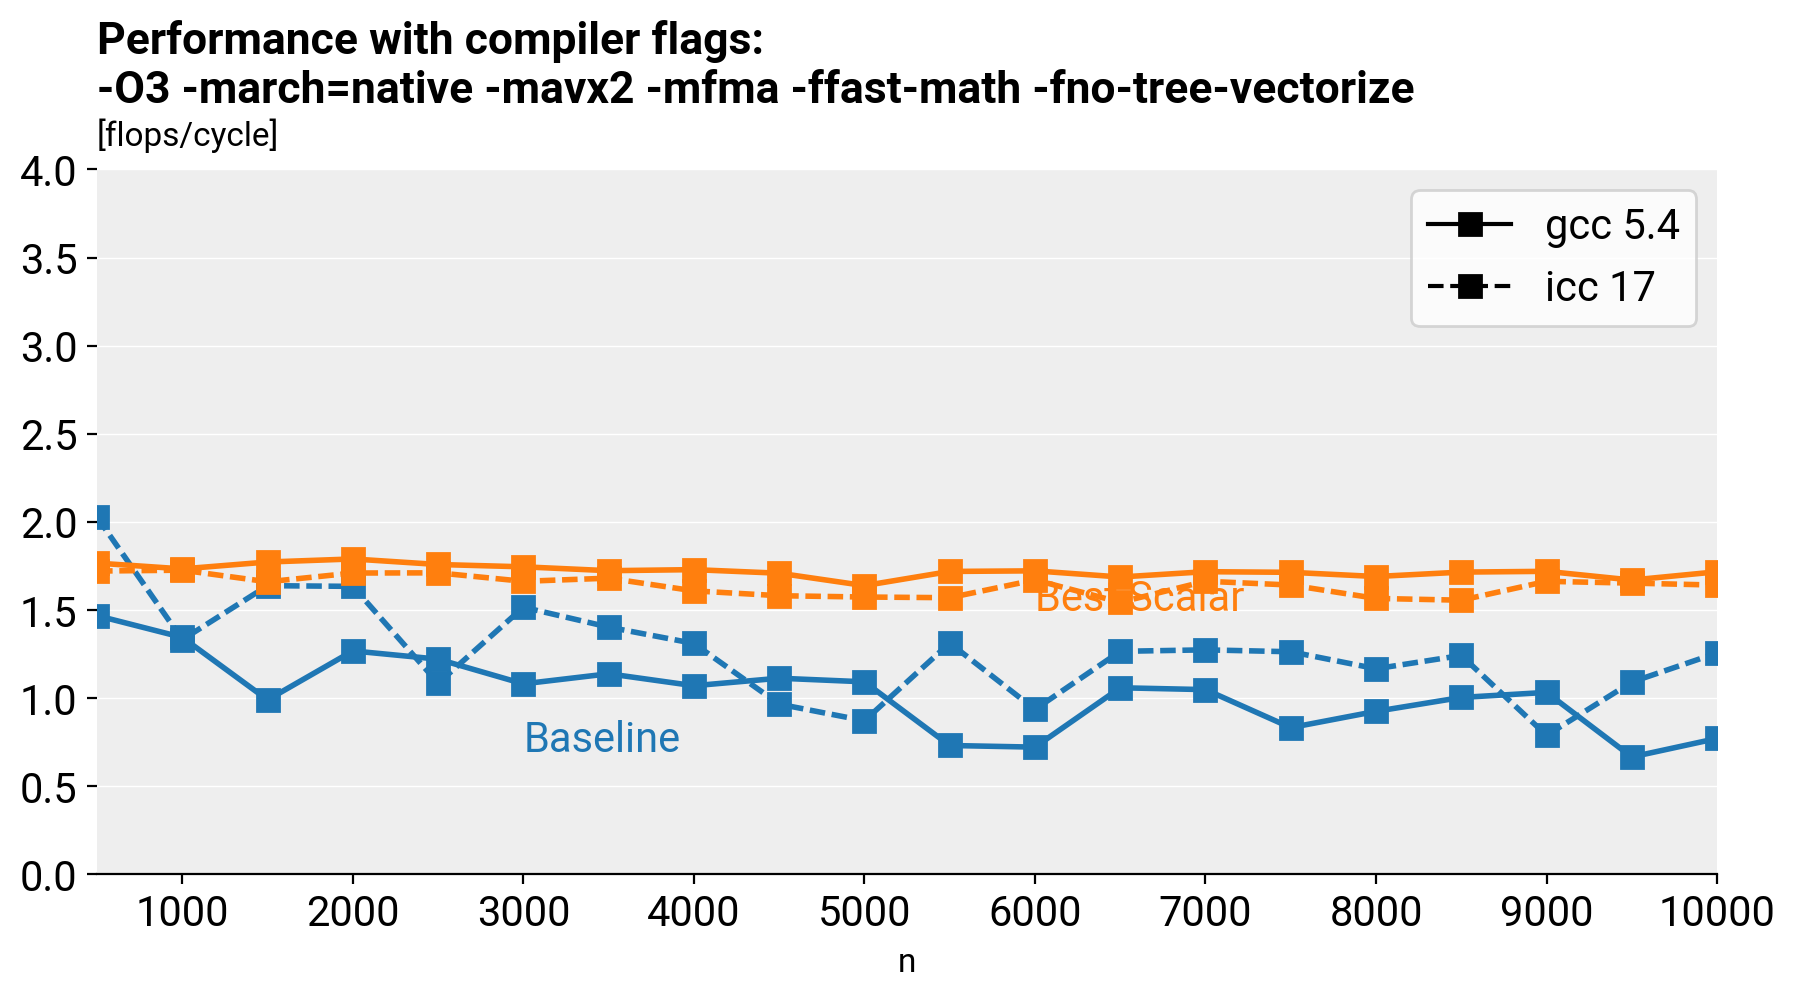

In [13]:
mpl.rcParams['figure.figsize'] = (8.1, 5)
title = "Performance with compiler flags: \n-O3 -march=native -mavx2 -mfma -ffast-math -fno-tree-vectorize"
ylabel = "flops/cycle"
legend = True
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ymax = 4

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.83, left=0, right=1)

base_gcc, = ax.plot(N, baseline_gcc_novec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline GCC")
base_icc, = ax.plot(N, baseline_icc_novec["perf"][:,-1], c=base_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline ICC")
scalar_gcc, = ax.plot(N, scalar_gcc_novec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar GCC")
scalar_icc, = ax.plot(N, scalar_icc_novec["perf"][:,-1], c=scalar_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar ICC")
#avx_gcc, = ax.plot(N, avx_gcc_vec["perf"][:,-1], 
#                linewidth=lw, marker=marker, markersize=markersize, label="AVX GCC")
#avx_icc, = ax.plot(N, avx_icc_vec["perf"][:,-1], c=avx_gcc.get_color(), linestyle="dashed",
#                linewidth=lw, marker=marker, markersize=markersize, label="AVX ICC")
gcc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", label="gcc 5.4")
icc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", linestyle="dashed", label="icc 17")
ax.legend(handles=[gcc_patch, icc_patch])

ax.text(3000, 0.7, "Baseline", color=base_gcc.get_color())
ax.text(6000, 1.5, "Best Scalar", color=scalar_gcc.get_color())
#ax.text(4000, 3.5, "Best AVX", color=avx_gcc.get_color(), fontweight="bold")

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)
ax.set_ylim([0, ymax])

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))

plt.show()

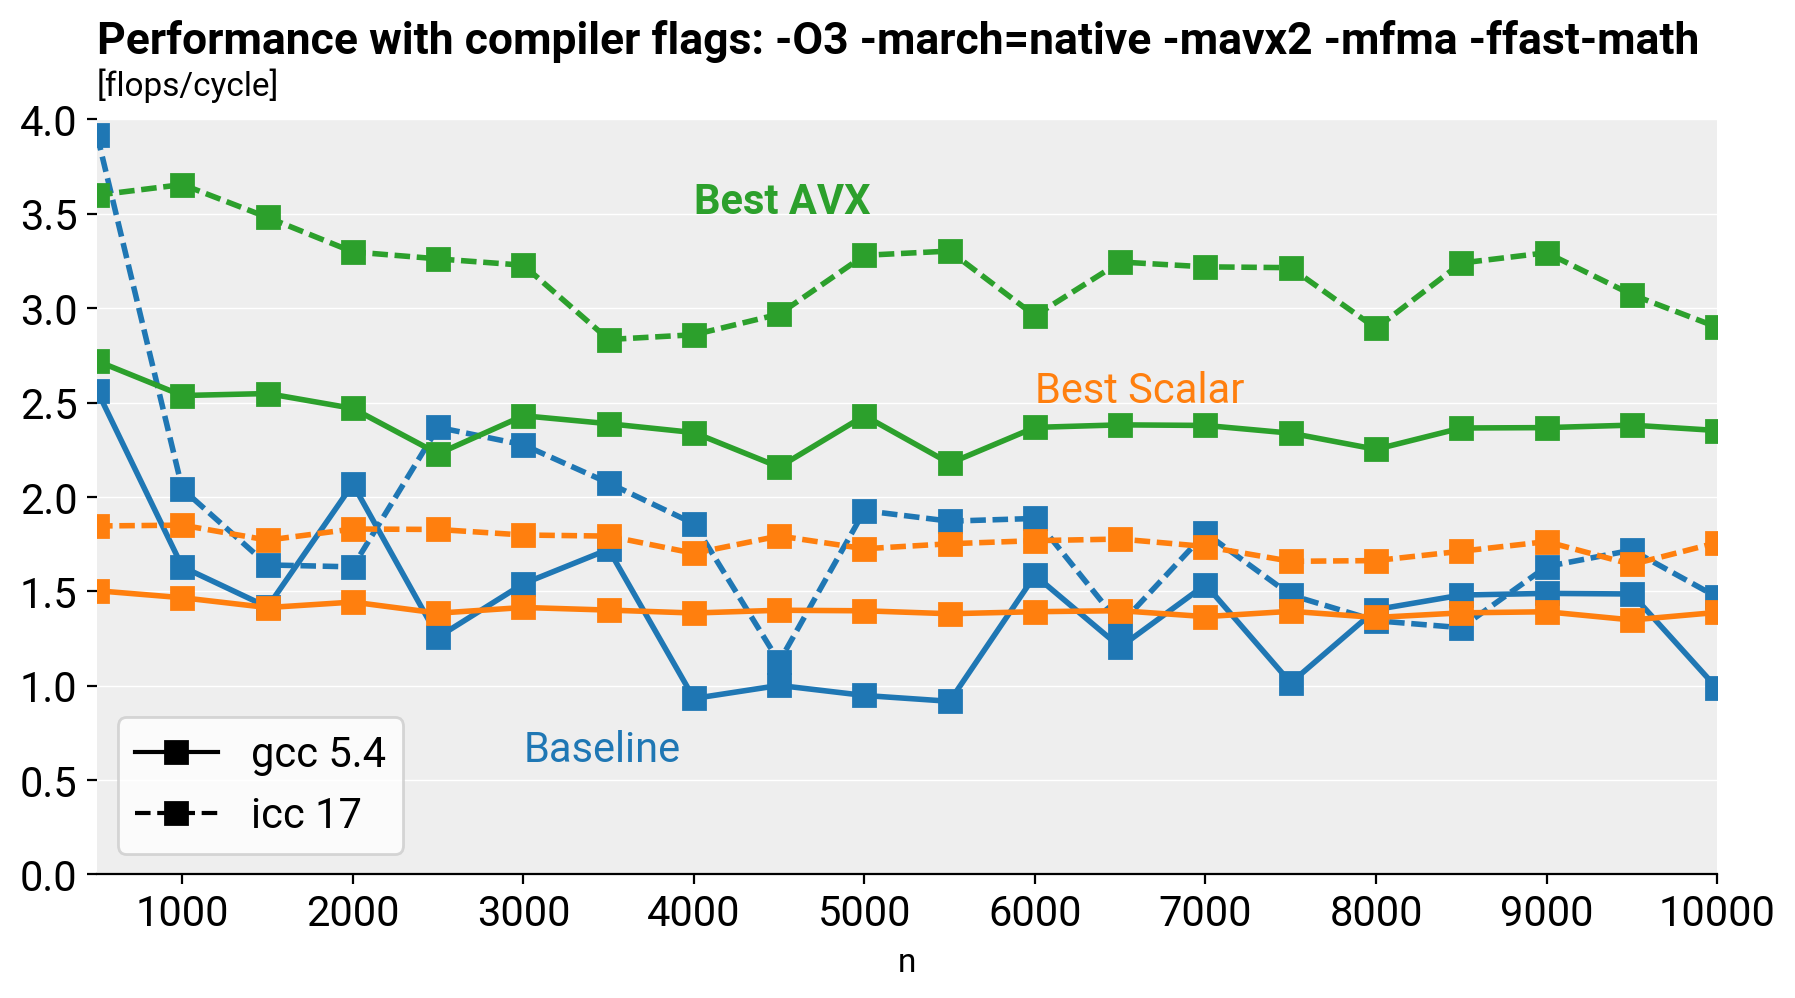

In [14]:
mpl.rcParams['figure.figsize'] = (8.1, 5)
title = r"Performance with compiler flags: -O3 -march=native -mavx2 -mfma -ffast-math"
ylabel = "flops/cycle"
legend = True
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ymax = 4

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

base_gcc, = ax.plot(N, baseline_gcc_vec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline GCC")
base_icc, = ax.plot(N, baseline_icc_vec["perf"][:,-1], c=base_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline ICC")
scalar_gcc, = ax.plot(N, scalar_gcc_vec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar GCC")
scalar_icc, = ax.plot(N, scalar_icc_vec["perf"][:,-1], c=scalar_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar ICC")
avx_gcc, = ax.plot(N, avx_gcc_vec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="AVX GCC")
avx_icc, = ax.plot(N, avx_icc_vec["perf"][:,-1], c=avx_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="AVX ICC")
gcc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", label="gcc 5.4")
icc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", linestyle="dashed", label="icc 17")
ax.legend(handles=[gcc_patch, icc_patch])

ax.text(3000, 0.6, "Baseline", color=base_gcc.get_color())
ax.text(6000, 2.5, "Best Scalar", color=scalar_gcc.get_color())
ax.text(4000, 3.5, "Best AVX", color=avx_gcc.get_color(), fontweight="bold")

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)
ax.set_ylim([0, ymax])

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))

plt.show()

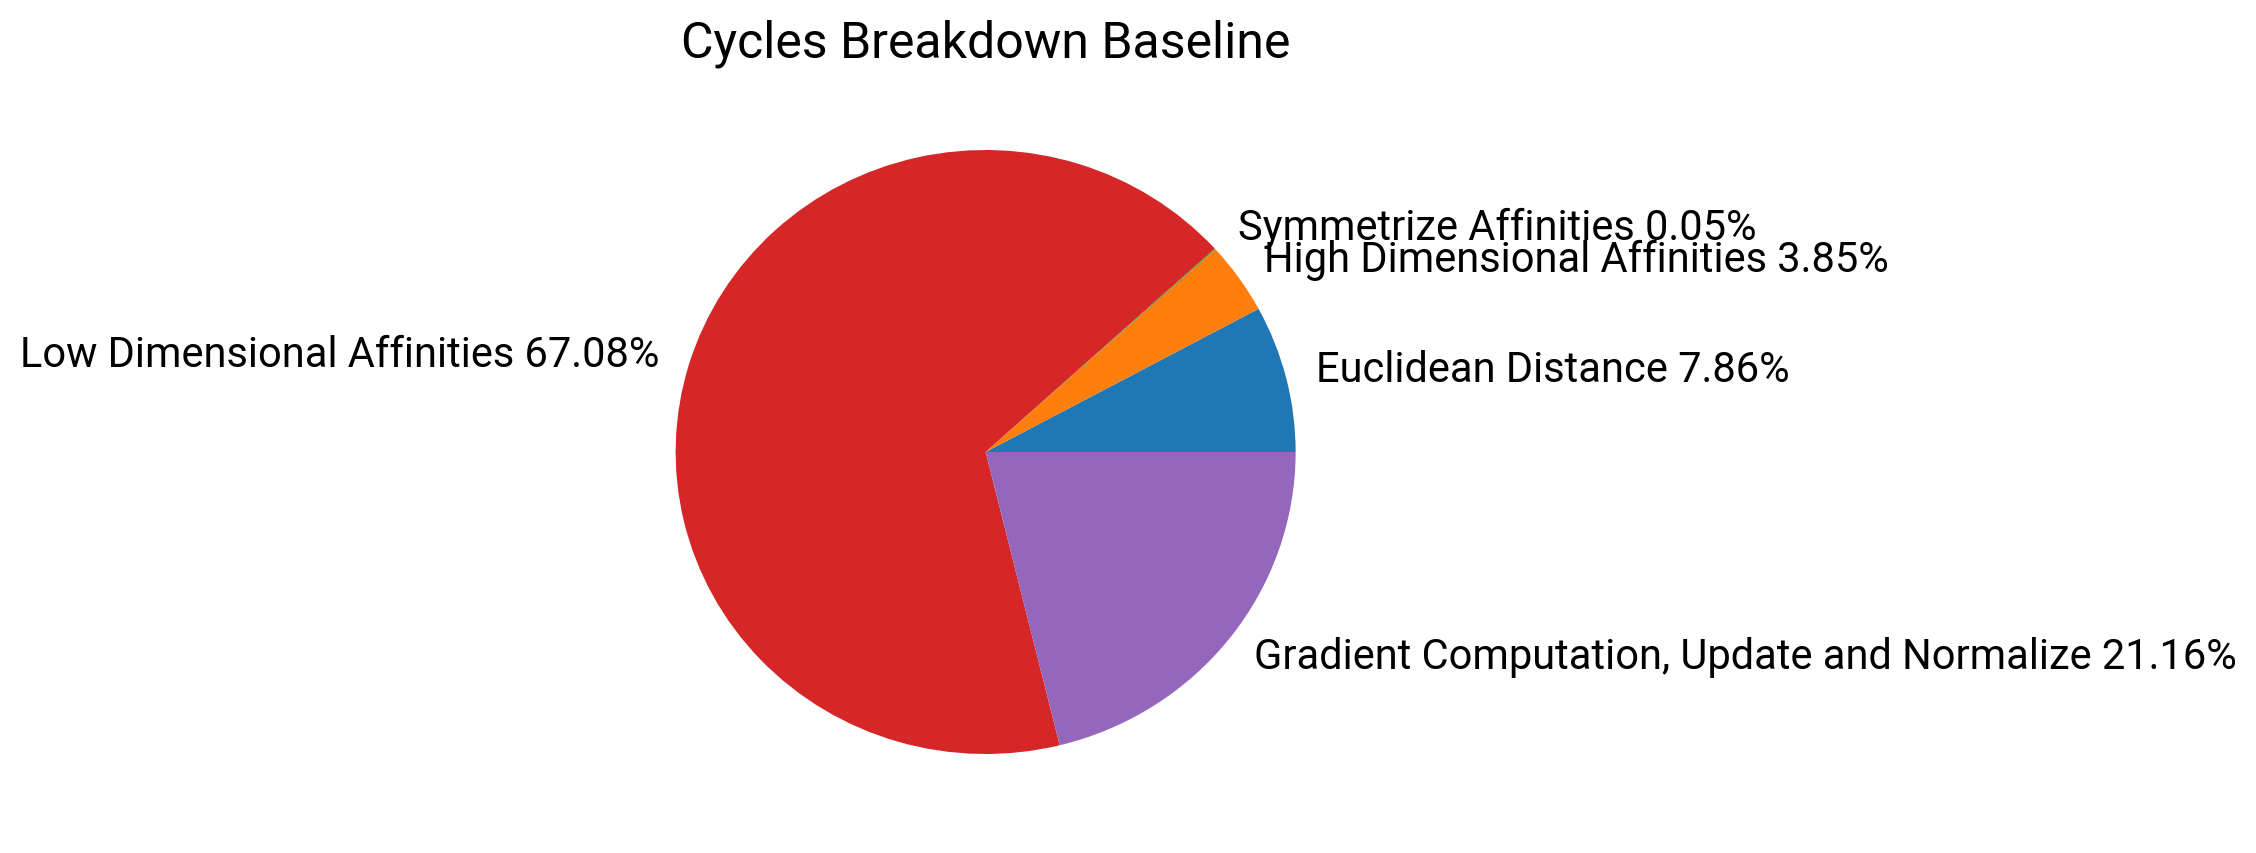

In [15]:
functions_list = [
    "Euclidean Distance",
    "High Dimensional Affinities",
    "Symmetrize Affinities",
    "Low Dimensional Affinities",
    "Gradient Computation, Update and Normalize"
]

# Compiler gcc and novec for baseline and scalar
disp_names = list(functions_list)
cycles_mean_baseline = baseline_gcc_novec["cycles"]
split = cycles_mean_baseline[:,:-1] / cycles_mean_baseline[:,-1:]
split = split.mean(axis=0)
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"

mpl.rcParams['figure.figsize'] = (5, 5)
_, t = plt.pie(split, labels = disp_names)
plt.title("Cycles Breakdown Baseline")

plt.show()

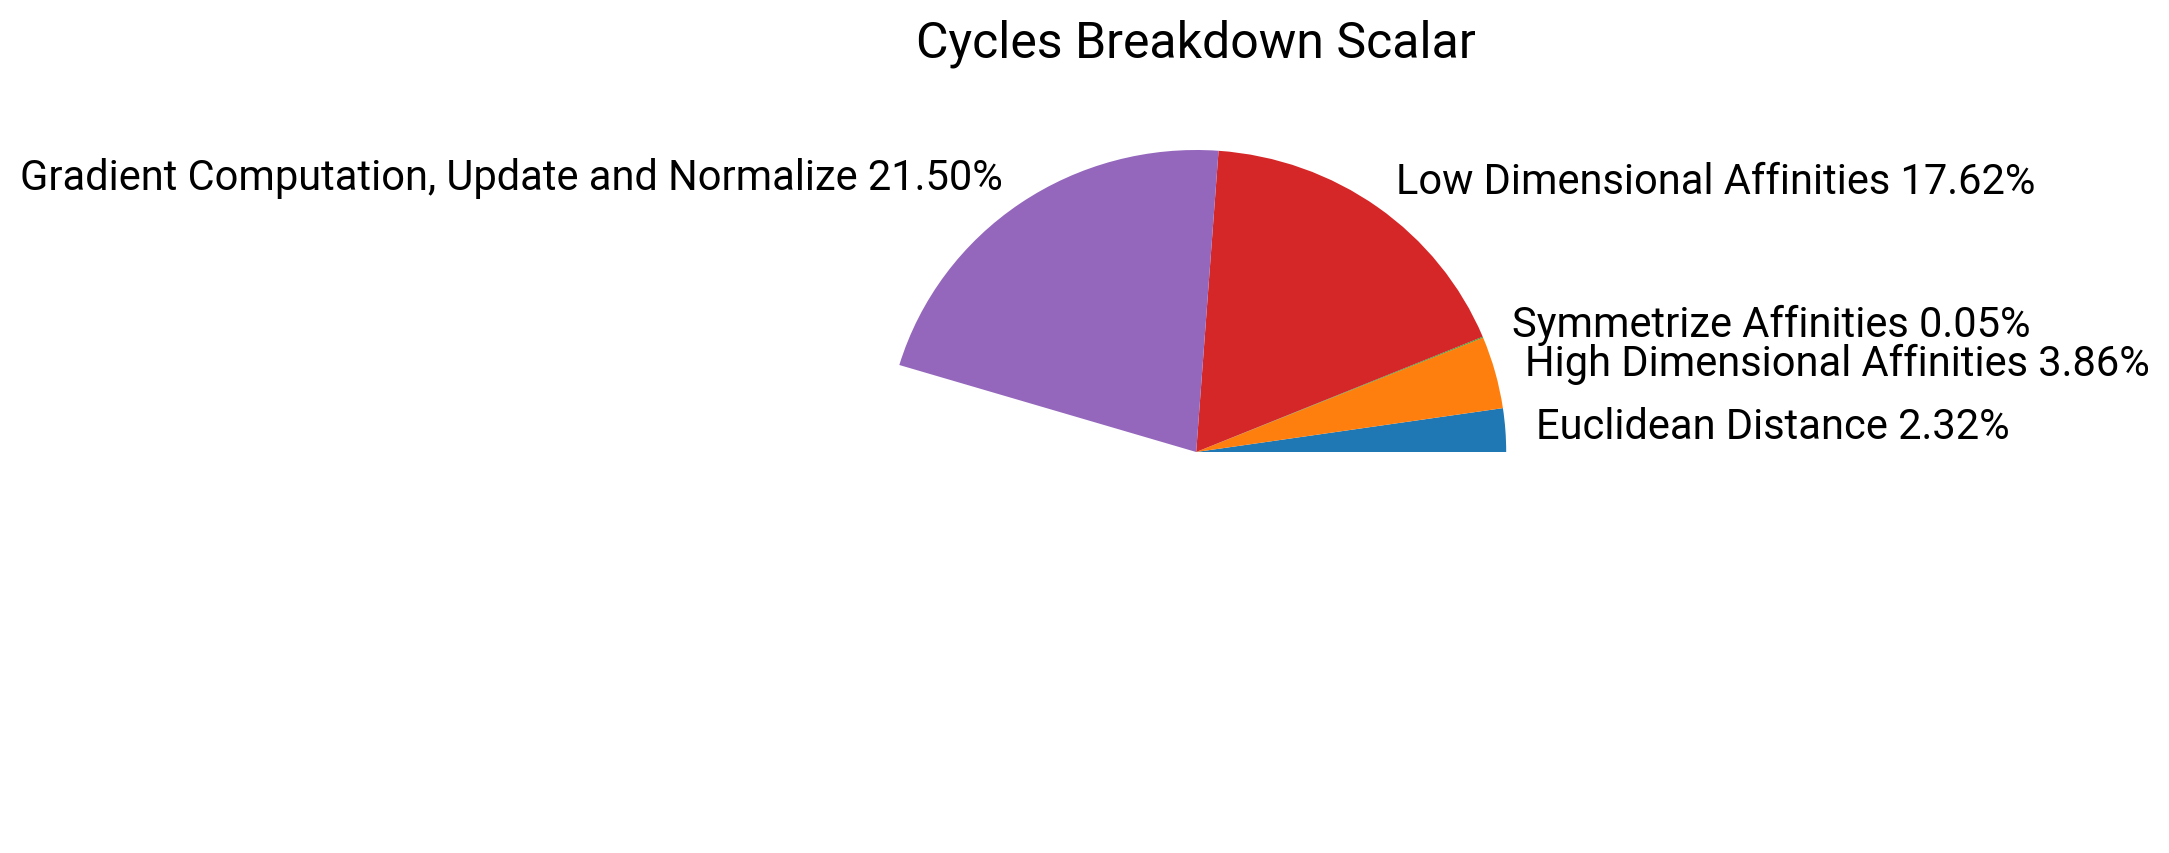

In [16]:
functions_list = [
    #"Difference",
    "Euclidean Distance",
    "High Dimensional Affinities",
    "Symmetrize Affinities",
    "Low Dimensional Affinities",
    "Gradient Computation, Update and Normalize"
]

# Compiler gcc and novec for baseline and scalar
disp_names = list(functions_list)
cycles_mean_scalar = scalar_gcc_novec["cycles"]
split = cycles_mean_scalar[:,:-1] / cycles_mean_baseline[:,-1:]
split = split.mean(axis=0)
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"

mpl.rcParams['figure.figsize'] = (5, 5)
_, t = plt.pie(split, labels = disp_names)
plt.title("Cycles Breakdown Scalar")

plt.show()

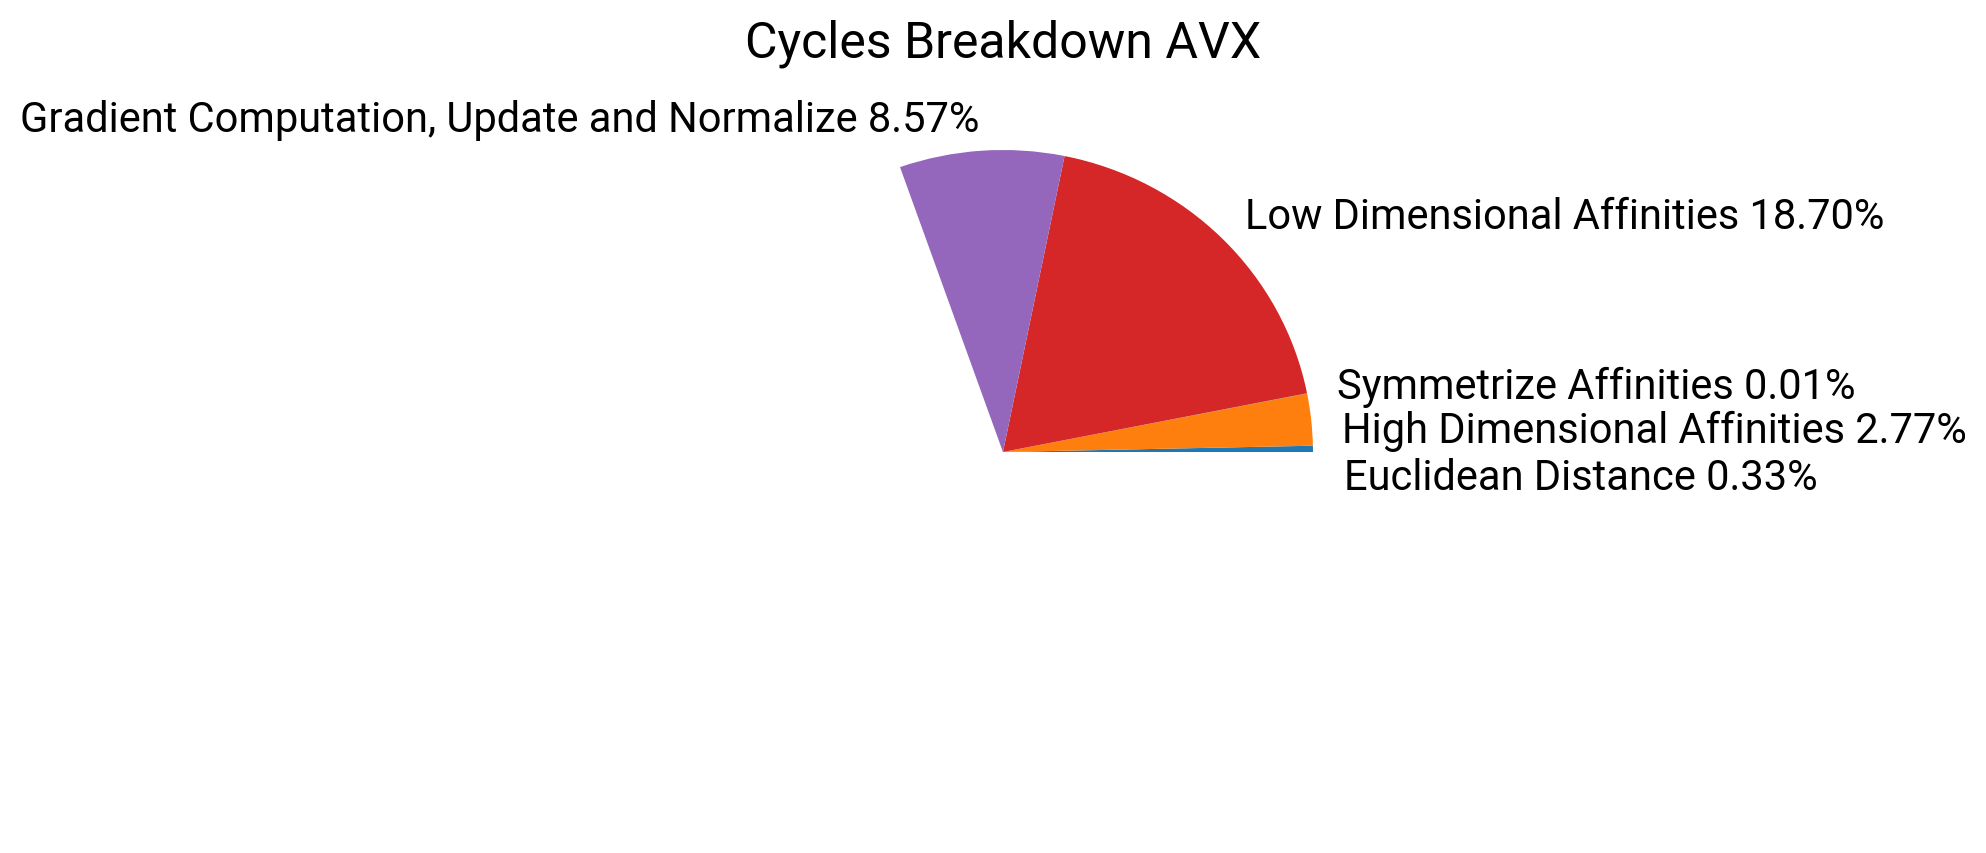

In [17]:
functions_list = [
    #"Difference",
    "Euclidean Distance",
    "High Dimensional Affinities",
    "Symmetrize Affinities",
    "Low Dimensional Affinities",
    "Gradient Computation, Update and Normalize"
]

# Compiler gcc and novec for baseline and scalar
disp_names = list(functions_list)
cycles_mean_avx = avx_gcc_vec["cycles"]
split = cycles_mean_avx[:,:-1] / cycles_mean_baseline[:,-1:]
split = split.mean(axis=0)
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"

mpl.rcParams['figure.figsize'] = (5, 5)
_, t = plt.pie(split, labels = disp_names)
(x, y) = t[0].get_position()
t[0].set_position((x, y-.1))
(x, y) = t[1].get_position()
t[1].set_position((x, y-.05))
plt.title("Cycles Breakdown AVX")

plt.show()

## Plots for Part 1

In [9]:
gcc_novec = pd.read_csv("../code/implementations/optimizations/high_dim_eucledian_distance/toaster_bench/gcc_novec_1000.csv")
gcc_vec = pd.read_csv("../code/implementations/optimizations/high_dim_eucledian_distance/toaster_bench/gcc_vec_1000.csv")
icc_novec = pd.read_csv("../code/implementations/optimizations/high_dim_eucledian_distance/toaster_bench/icc_novec_1000.csv")
icc_vec = pd.read_csv("../code/implementations/optimizations/high_dim_eucledian_distance/toaster_bench/icc_vec_1000.csv")

functions_no_vec = list(gcc_novec.columns.values)[2:]
functions_vec = list(gcc_vec.columns.values)[2:]

In [52]:
D = 1000
def get_flops(N, d):
    W = 2*N+2*d + N*d + (1.5)*d*N*(N-1)
    return W

def get_flops_avx(N, d):
    W = (d//8) * ( (N//8) * 64 + (N%8) * 8 + 7*8 + N*8 ) + (d%8) * (8 * (N//8) + (N%8) + 7 +N )
    W += d + 1
    W += 2
    W += (N//8) * (112*d + 448 + ( (N//8) -1) * (64*d + 256) + (N%8)*(2*d + 8) )
    W += (N//8) * (56*d + 56 + ( (N//8) -1) * (32*d + 4) + (N%8)*(1*d + 1) )
    return W

N = gcc_novec["N"]
flops = get_flops(N, D)
basline_gcc_novec = flops/gcc_novec["base_version"]
fastscalar_gcc_novec = flops/gcc_novec["fast_scalar"]
fastscalarStart_gcc_novec = flops/gcc_novec["fast_scalar_start_matter"]
unroll888_gcc_novec = flops/gcc_novec["fast_scalar_8x8x8_big_unroll"]
basline_icc_novec = flops/icc_novec["base_version"]
fastscalar_icc_novec = flops/icc_novec["fast_scalar"]
fastscalarStart_icc_novec = flops/icc_novec["fast_scalar_start_matter"]
unroll888_icc_novec = flops/icc_novec["fast_scalar_8x8x8_big_unroll"]

basline_gcc_vec = flops/gcc_vec["base_version"]
fastscalar_gcc_vec = flops/gcc_vec["fast_scalar"]
fastscalarStart_gcc_vec = flops/gcc_vec["fast_scalar_start_matter"]
unroll888_gcc_vec = flops/gcc_vec["fast_scalar_8x8x8_big_unroll"]
basline_icc_vec = flops/icc_vec["base_version"]
fastscalar_icc_vec = flops/icc_vec["fast_scalar"]
fastscalarStart_icc_vec = flops/icc_vec["fast_scalar_start_matter"]
unroll888_icc_vec = flops/icc_vec["fast_scalar_8x8x8_big_unroll"]
avx_gcc_vec = get_flops_avx(N, D)/gcc_vec["fast_scalar_8x8x8_avx"]
avxStart_gcc_vec = get_flops_avx(N, D)/gcc_vec["fast_scalar_8x8x8_avx_with_start"]
avx_icc_vec = get_flops_avx(N, D)/icc_vec["fast_scalar_8x8x8_avx"]
avxStart_icc_vec = get_flops_avx(N, D)/icc_vec["fast_scalar_8x8x8_avx_with_start"]

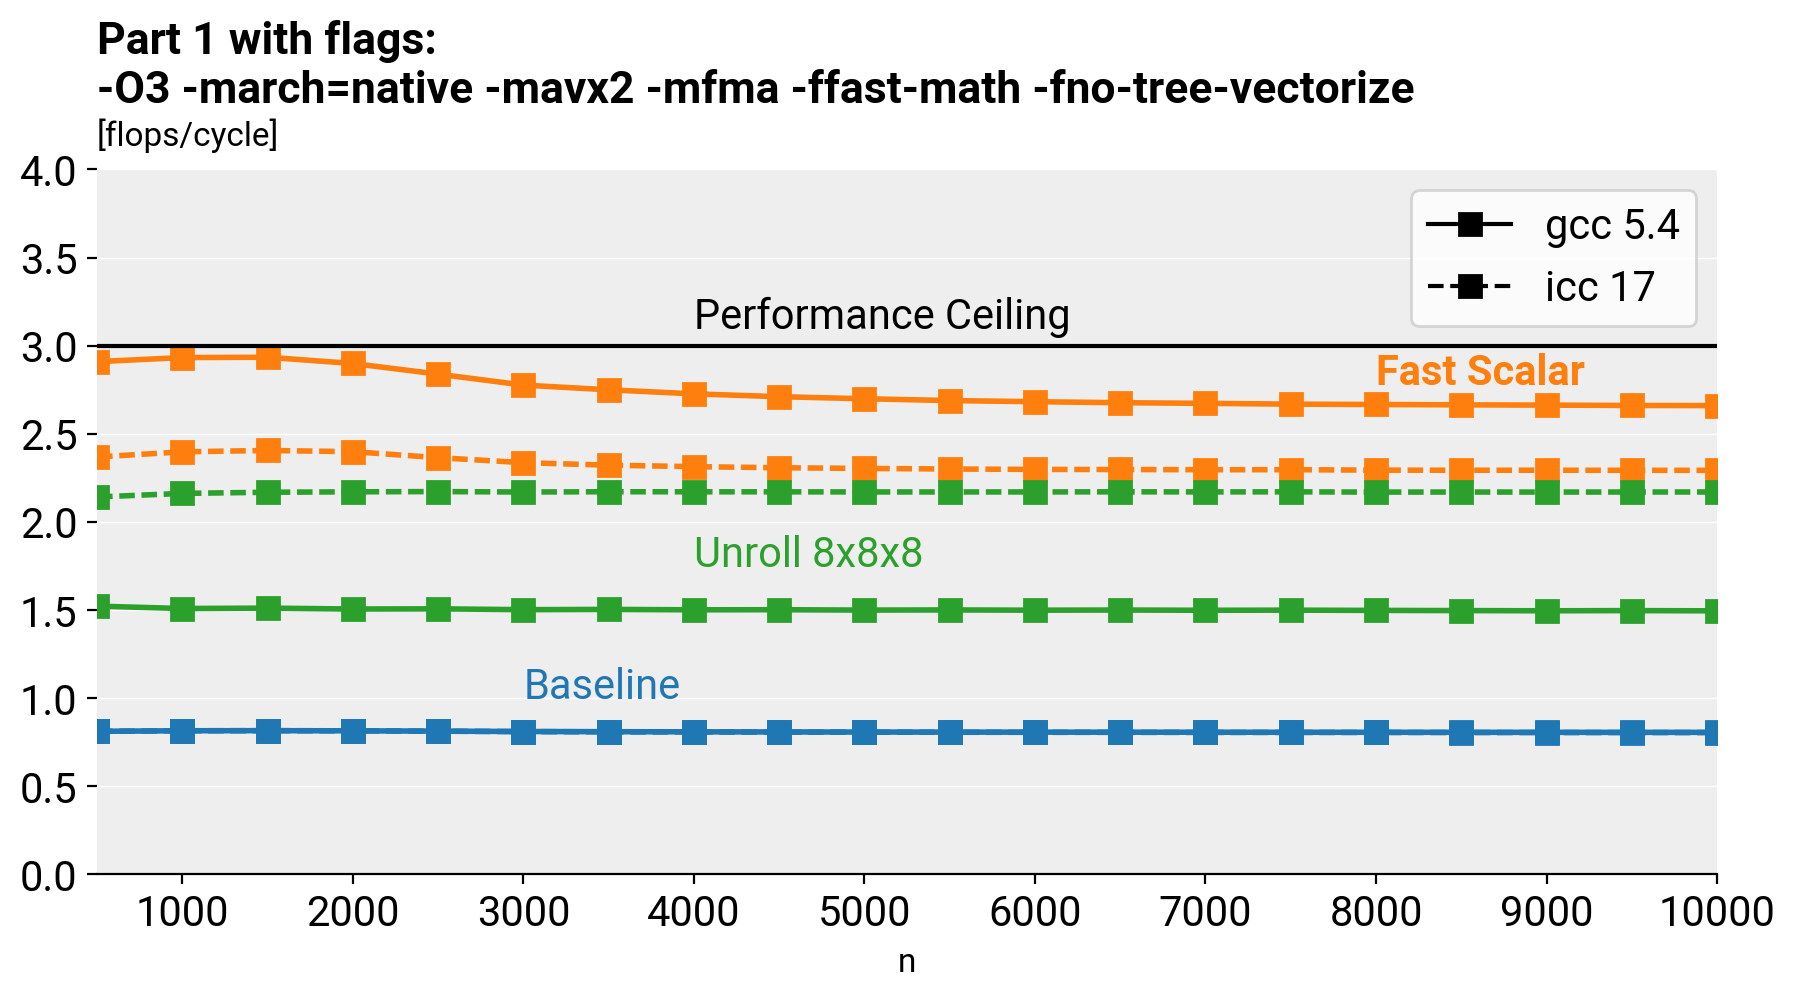

In [61]:
mpl.rcParams['figure.figsize'] = (8.1, 5)
title = "Part 1 with flags: \n-O3 -march=native -mavx2 -mfma -ffast-math -fno-tree-vectorize"
ylabel = "flops/cycle"
legend = True
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ymax = 4

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.83, left=0, right=1)

base_gcc, = ax.plot(N, basline_gcc_novec, 
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline GCC")
base_icc, = ax.plot(N, basline_icc_novec, c=base_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline ICC")
# scalar_gcc, = ax.plot(N, fastscalar_gcc_novec, 
#                 linewidth=lw, marker=marker, markersize=markersize, label="Scalar GCC")
# scalar_icc, = ax.plot(N, fastscalar_icc_novec, c=scalar_gcc.get_color(), linestyle="dashed",
#                 linewidth=lw, marker=marker, markersize=markersize, label="Scalar ICC")
scalarStart_gcc, = ax.plot(N, fastscalarStart_gcc_novec, 
               linewidth=lw, marker=marker, markersize=markersize, label="Scalar+Start GCC")
scalarStart_icc, = ax.plot(N, fastscalarStart_icc_novec, c=scalarStart_gcc.get_color(), linestyle="dashed",
               linewidth=lw, marker=marker, markersize=markersize, label="Scalar+Start ICC")
scalar888_gcc, = ax.plot(N, unroll888_gcc_novec, 
               linewidth=lw, marker=marker, markersize=markersize, label="Unroll 8x8x8 GCC")
scalar888_icc, = ax.plot(N, unroll888_icc_novec, c=scalar888_gcc.get_color(), linestyle="dashed",
               linewidth=lw, marker=marker, markersize=markersize, label="Unroll 8x8x8 ICC")
gcc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", label="gcc 5.4")
icc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", linestyle="dashed", label="icc 17")
ax.legend(handles=[gcc_patch, icc_patch])

ax.text(3000, 1.0, "Baseline", color=base_gcc.get_color())
# ax.text(6000, 1.5, "Fast Scalar", color=scalar_gcc.get_color(), fontweight="bold")
ax.text(8000, 2.78, "Fast Scalar", color=scalarStart_gcc.get_color(), fontweight="bold")
ax.text(4000, 1.75, "Unroll 8x8x8", color=scalar888_gcc.get_color())
ax.text(4000, 3.1, "Performance Ceiling", color="black")

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)
ax.set_ylim([0, ymax])

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.plot([0, np.max(10000)], [3, 3], 'k-')

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))

plt.show()



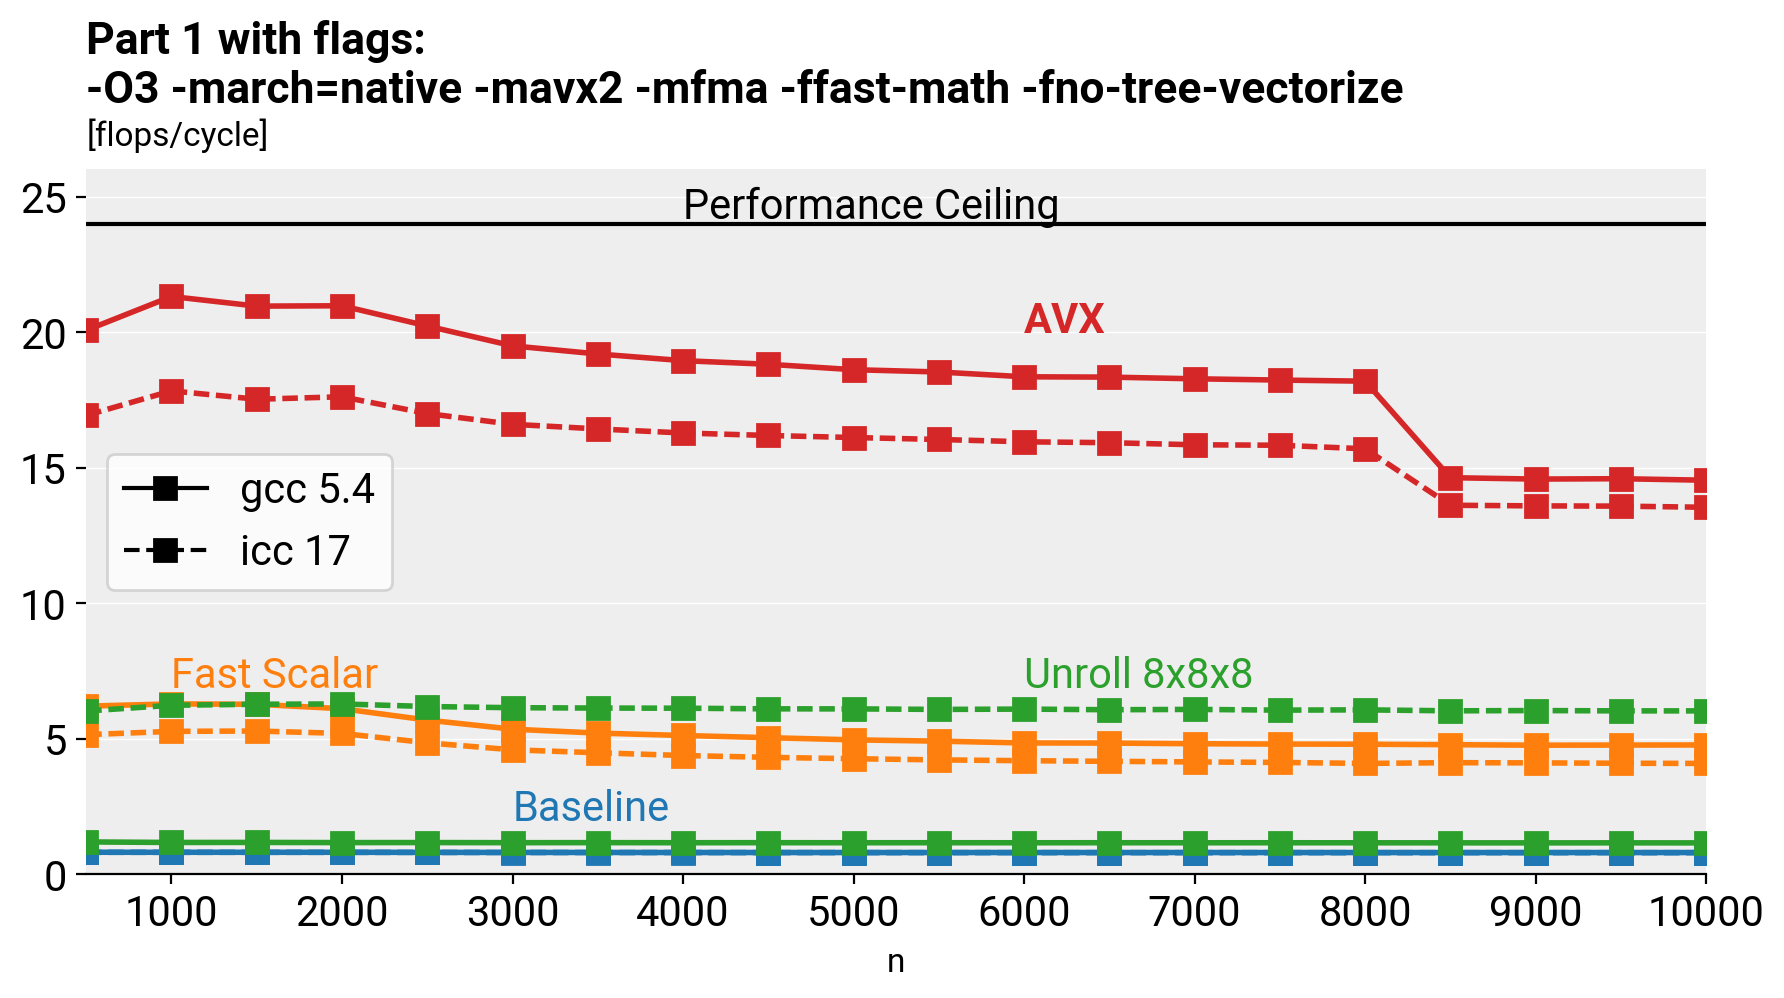

In [56]:
mpl.rcParams['figure.figsize'] = (8.1, 5)
title = "Part 1 with flags: \n-O3 -march=native -mavx2 -mfma -ffast-math -fno-tree-vectorize"
ylabel = "flops/cycle"
legend = True
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ymax = 26


fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.83, left=0, right=1)

base_gcc, = ax.plot(N, basline_gcc_vec, 
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline GCC")
base_icc, = ax.plot(N, basline_icc_vec, c=base_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline ICC")
# scalar_gcc, = ax.plot(N, fastscalar_gcc_vec, 
#                 linewidth=lw, marker=marker, markersize=markersize, label="Scalar GCC")
# scalar_icc, = ax.plot(N, fastscalar_icc_vec, c=scalar_gcc.get_color(), linestyle="dashed",
#                 linewidth=lw, marker=marker, markersize=markersize, label="Scalar ICC")
scalarStart_gcc, = ax.plot(N, fastscalarStart_gcc_vec, 
               linewidth=lw, marker=marker, markersize=markersize, label="Scalar+Start GCC")
scalarStart_icc, = ax.plot(N, fastscalarStart_icc_vec, c=scalarStart_gcc.get_color(), linestyle="dashed",
               linewidth=lw, marker=marker, markersize=markersize, label="Scalar+Start ICC")
scalar888_gcc, = ax.plot(N, unroll888_gcc_vec, 
               linewidth=lw, marker=marker, markersize=markersize, label="Unroll 8x8x8 GCC")
scalar888_icc, = ax.plot(N, unroll888_icc_vec, c=scalar888_gcc.get_color(), linestyle="dashed",
               linewidth=lw, marker=marker, markersize=markersize, label="Unroll 8x8x8 ICC")

# avx_gcc, = ax.plot(N, avx_gcc_vec, 
#                linewidth=lw, marker=marker, markersize=markersize, label="AVX GCC")
# avx_icc, = ax.plot(N, avx_icc_vec, c=avx_gcc.get_color(), linestyle="dashed",
#                linewidth=lw, marker=marker, markersize=markersize, label="AVX ICC")

avxStart_gcc, = ax.plot(N, avxStart_gcc_vec, 
               linewidth=lw, marker=marker, markersize=markersize, label="AVX+Start GCC")
avxStart_icc, = ax.plot(N, avxStart_icc_vec, c=avxStart_gcc.get_color(), linestyle="dashed",
               linewidth=lw, marker=marker, markersize=markersize, label="AVX+Start ICC")

gcc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", label="gcc 5.4")
icc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", linestyle="dashed", label="icc 17")
ax.legend(handles=[gcc_patch, icc_patch])

ax.text(3000, 2, "Baseline", color=base_gcc.get_color())
ax.text(1000, 6.9, "Fast Scalar", color=scalar_gcc.get_color())
ax.text(6000, 6.9, "Unroll 8x8x8", color=scalar888_gcc.get_color())
ax.text(6000, 20, "AVX", color=avxStart_gcc.get_color(), fontweight="bold")
ax.text(4000, 24.2, "Performance Ceiling", color="black")

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)
ax.set_ylim([0, ymax])




# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))

plt.plot([0, np.max(10000)], [24, 24], 'k-')

plt.show()

